In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# check GPU status
!nvidia-smi

Sun Feb  2 10:40:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:E3:00.0 Off |                    0 |
|  0%   37C    P0             73W /  300W |   20837MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 1. load config
import json
# config_fname = 'configs/ours-pretrain-registration-patchify-video.json'
config_fname = 'configs/ours-pretrain-registration-aligned-frames.json'

config = json.load(open(config_fname))

In [5]:
check_dict(config)

data                                                         dict_keys(['DENSE_filenames', 'cine_filenames', 'train_subject_exclude_patterns', 'val_subject_patterns', 'test_subject_patterns'])
datasets                                                     dict_keys(['train', 'val', 'test'])
networks                                                     dict_keys(['registration'])
training                                                     dict_keys(['seed', 'scheme', 'batch_forward_method', 'reg_forward_data', 'regression_output_type', 'mask_padded_frames', 'resize_before_regression', 'batch_size', 'epochs', 'enable_random_rotate', 'random_rotate_prob_thres', 'epochs_without_improvement_tolerance', 'disp_masking', 'disp_mask_key', 'save_best_model_interval', 'training_latent_model_epoch_interval', 'training_motion_decoder_epoch_interval', 'optimization'])
losses                                                       dict_keys(['registration_reconstruction'])
evaluation                     

In [6]:
from modules.data import glob_star
import json
import glob

def load_DENSE_data(DENSE_data_fnames):
    # Load raw data
    all_data_raw = []
    all_data_fnames = list(glob_star(DENSE_data_fnames))
    for all_data_fname in all_data_fnames:
        all_data_raw += np.load(all_data_fname, allow_pickle=True).tolist()
    
    # Keep only the necessary files
    all_data = []
    for datum_idx, datum_raw in enumerate(all_data_raw):
        loaded_datum = {}

        # loaded_datum = get_data_from_slice(datum_raw, data_to_feed)        
        loaded_datum['DENSE_disp'] = np.stack([datum_raw['DENSE_Lag_displacement_field_X'], datum_raw['DENSE_Lag_displacement_field_Y']], axis=0)
        loaded_datum['myo_masks'] = datum_raw['DENSE_myo_masks_rescaled']#[None]
        # loaded_datum['PositionA'] = datum_raw['AnalysisInfo']['PositionA']
        # loaded_datum['PositionB'] = datum_raw['AnalysisInfo']['PositionB']
        loaded_datum['slice_mat_filename'] = str(datum_raw.get('DENSE_slice_mat_filename', 'None'))
        loaded_datum['slice_location'] = float(datum_raw.get('DENSE_slice_location', -1e-3))
        
        loaded_datum['subject_id'] = datum_raw['patient_id']
        loaded_datum['slice_idx'] = datum_idx
        loaded_datum['slice_full_id'] = f'{datum_raw["patient_id"]}-{datum_idx}'
        loaded_datum['SequenceInfo'] = datum_raw['SequenceInfo']
        loaded_datum['ori_n_frames'] = loaded_datum['myo_masks'].shape[-1]

        all_data.append(loaded_datum)
    return all_data

all_data = load_DENSE_data(config['data']['DENSE_filenames'])

In [8]:
# 2. load all data splits
train_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') not in config['data']['train_subject_exclude_patterns']]
}
val_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['val_subject_patterns']]
}
test_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['test_subject_patterns']]
}

data_splits = {
    'train': train_split,
    'val': val_split,
    'test': test_split
}

In [9]:
check_dict(train_split['data'][0])

DENSE_disp                                                   (2, 48, 48, 22)     
myo_masks                                                    (128, 128, 22)      
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
SequenceInfo                                                 (2, 3)              
ori_n_frames                                                 22                  


In [10]:
# 4. Building dataset
from modules.data.dataset import build_datasets
datasets = build_datasets(data_splits, config['datasets'])
# print the length of each dataset
for dataset_name, dataset in datasets.items():
    print(f'{dataset_name} dataset length: {len(dataset)}')

Aligning displacement field frames to 41 frames
# of frames before alignment: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 75]
# of frames after alignment: [41]
Using Lagrangian displacement field
Aligning displacement field frames to 41 frames
# of frames before alignment: [65, 39, 41, 43, 45, 47, 49, 29, 51, 53, 30, 24, 57, 59, 61, 25, 31]
# of frames after alignment: [41]
Using Lagrangian displacement field
Aligning displacement field frames to 41 frames
# of frames before alignment: [20, 21, 24, 25, 29, 30, 31, 33, 35, 37, 39, 41, 43, 47, 49, 51, 55, 57, 59, 63, 65]
# of frames after alignment: [41]
Using Lagrangian displacement field
train dataset length: 718
val dataset length: 128
test dataset length: 166


In [11]:
check_dict(datasets['train'][0])

src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
ori_n_frames                                                 22                  


In [12]:
check_dict(datasets['train'][-1])

src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-analyzed-cine-data/UVA12/all_AUTO_FUNCTION_1_40.mat
slice_location                                               91.61637674809      
subject_id                                                   UVA12               
slice_idx                                                    270                 
slice_full_id                                                UVA12-270           
ori_n_frames                                                 25                  


In [13]:
# 6. Building model
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to( device)
# model = build_model(config['network'])

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth


In [14]:
# Training
from modules.trainer import build_trainer
config['training']['epochs'] = 15 # set only 30 epochs for debugging
config['training']['batch_size'] = 16 # can use larger batch size if use patchified video
config['training']['learning_rate'] = 1e-4
trainer = build_trainer(config['training'], device, config)

In [15]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

registration lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f7fefeea920>


  0%|          | 0/15 [00:00<?, ?it/s]

45it [00:33,  1.33it/s]
8it [00:02,  3.12it/s].377e+00:   0%|          | 0/15 [00:34<?, ?it/s]
Epoch 0 | Train Loss 3.377e+00:   7%|▋         | 1/15 [00:36<08:33, 36.65s/it]

{
    "train/registration_reconstruction": 4.112656995985243,
    "train/total_loss": 4.115971242905491,
    "train/reconstruction_error": 0.0033142469202478726,
    "val/registration_reconstruction": 4.107773542404175,
    "val/total_loss": 4.111049714963883,
    "val/reconstruction_error": 0.003276172559708357
}


45it [00:31,  1.42it/s]
8it [00:02,  3.17it/s].471e+00:   7%|▋         | 1/15 [01:08<08:33, 36.65s/it]
Epoch 1 | Train Loss 3.471e+00:  13%|█▎        | 2/15 [01:11<07:41, 35.47s/it]

{
    "train/registration_reconstruction": 4.082631169425117,
    "train/total_loss": 4.0859191970796225,
    "train/reconstruction_error": 0.0032880276545054384,
    "val/registration_reconstruction": 4.050552695989609,
    "val/total_loss": 4.053704800491687,
    "val/reconstruction_error": 0.0031521045020781457
}


45it [00:31,  1.41it/s]
8it [00:02,  3.17it/s].160e+00:  13%|█▎        | 2/15 [01:43<07:41, 35.47s/it]
Epoch 2 | Train Loss 4.160e+00:  20%|██        | 3/15 [01:46<07:01, 35.12s/it]

{
    "train/registration_reconstruction": 4.064363225301107,
    "train/total_loss": 4.067620022750149,
    "train/reconstruction_error": 0.0032567974490423997,
    "val/registration_reconstruction": 4.058314174413681,
    "val/total_loss": 4.061571070138598,
    "val/reconstruction_error": 0.0032568957249168307
}
Epochs without improvement: 1 / 30


45it [00:31,  1.42it/s]
8it [00:02,  3.15it/s].210e+00:  20%|██        | 3/15 [02:18<07:01, 35.12s/it]
Epoch 3 | Train Loss 4.210e+00:  27%|██▋       | 4/15 [02:20<06:24, 34.94s/it]

{
    "train/registration_reconstruction": 4.061637009514703,
    "train/total_loss": 4.06487083228098,
    "train/reconstruction_error": 0.0032338227662775253,
    "val/registration_reconstruction": 4.074584394693375,
    "val/total_loss": 4.077715319552226,
    "val/reconstruction_error": 0.0031309248588513583
}
Epochs without improvement: 2 / 30


45it [00:31,  1.41it/s]
8it [00:02,  3.15it/s].152e+00:  27%|██▋       | 4/15 [02:52<06:24, 34.94s/it]
Epoch 4 | Train Loss 4.152e+00:  33%|███▎      | 5/15 [02:55<05:48, 34.90s/it]

{
    "train/registration_reconstruction": 4.0692174434661865,
    "train/total_loss": 4.072422403981909,
    "train/reconstruction_error": 0.0032049605157226323,
    "val/registration_reconstruction": 4.041888773441315,
    "val/total_loss": 4.045031400601147,
    "val/reconstruction_error": 0.0031426271598320454
}


45it [00:31,  1.41it/s]
8it [00:02,  3.22it/s].799e+00:  33%|███▎      | 5/15 [03:27<05:48, 34.90s/it]
Epoch 5 | Train Loss 3.799e+00:  40%|████      | 6/15 [03:30<05:13, 34.82s/it]

{
    "train/registration_reconstruction": 4.05007168451945,
    "train/total_loss": 4.053262281666199,
    "train/reconstruction_error": 0.0031905971467494965,
    "val/registration_reconstruction": 4.031559377908707,
    "val/total_loss": 4.034647342981771,
    "val/reconstruction_error": 0.0030879650730639696
}


45it [00:32,  1.41it/s]
8it [00:02,  3.16it/s].802e+00:  40%|████      | 6/15 [04:02<05:13, 34.82s/it]
Epoch 6 | Train Loss 4.802e+00:  47%|████▋     | 7/15 [04:05<04:38, 34.85s/it]

{
    "train/registration_reconstruction": 4.067455244064331,
    "train/total_loss": 4.070703277985255,
    "train/reconstruction_error": 0.003248033920923869,
    "val/registration_reconstruction": 4.074088752269745,
    "val/total_loss": 4.077343421871774,
    "val/reconstruction_error": 0.0032546696020290256
}
Epochs without improvement: 1 / 30


45it [00:31,  1.42it/s]
8it [00:02,  2.79it/s].034e+00:  47%|████▋     | 7/15 [04:37<04:38, 34.85s/it]
Epoch 7 | Train Loss 4.034e+00:  53%|█████▎    | 8/15 [04:40<04:04, 34.90s/it]

{
    "train/registration_reconstruction": 4.054325024286906,
    "train/total_loss": 4.057544741003464,
    "train/reconstruction_error": 0.003219716716557741,
    "val/registration_reconstruction": 4.038415372371674,
    "val/total_loss": 4.041542414488504,
    "val/reconstruction_error": 0.0031270421168301255
}
Epochs without improvement: 2 / 30


45it [00:32,  1.39it/s]
8it [00:02,  3.13it/s].815e+00:  53%|█████▎    | 8/15 [05:12<04:04, 34.90s/it]
Epoch 8 | Train Loss 3.815e+00:  60%|██████    | 9/15 [05:15<03:29, 35.00s/it]

{
    "train/registration_reconstruction": 4.055498366885715,
    "train/total_loss": 4.058742823617326,
    "train/reconstruction_error": 0.003244456731610828,
    "val/registration_reconstruction": 4.106936305761337,
    "val/total_loss": 4.110465607227525,
    "val/reconstruction_error": 0.003529301466187462
}
Epochs without improvement: 3 / 30


45it [00:31,  1.41it/s]
8it [00:02,  3.16it/s].064e+00:  60%|██████    | 9/15 [05:47<03:29, 35.00s/it]
Epoch 9 | Train Loss 4.064e+00:  67%|██████▋   | 10/15 [05:50<02:54, 34.92s/it]

{
    "train/registration_reconstruction": 4.05316325293647,
    "train/total_loss": 4.056372163470628,
    "train/reconstruction_error": 0.003208910534158349,
    "val/registration_reconstruction": 4.042109042406082,
    "val/total_loss": 4.045150645630201,
    "val/reconstruction_error": 0.0030416032241191715
}
Epochs without improvement: 4 / 30


45it [00:31,  1.41it/s]
8it [00:02,  3.20it/s]4.885e+00:  67%|██████▋   | 10/15 [06:22<02:54, 34.92s/it]
Epoch 10 | Train Loss 4.885e+00:  73%|███████▎  | 11/15 [06:24<02:19, 34.86s/it]

{
    "train/registration_reconstruction": 4.066237285402086,
    "train/total_loss": 4.0694789268956,
    "train/reconstruction_error": 0.00324164149351418,
    "val/registration_reconstruction": 4.050992161035538,
    "val/total_loss": 4.054198628902668,
    "val/reconstruction_error": 0.0032064678671304137
}
Epochs without improvement: 5 / 30


45it [00:31,  1.42it/s]
8it [00:02,  3.18it/s]4.026e+00:  73%|███████▎  | 11/15 [06:56<02:19, 34.86s/it]
Epoch 11 | Train Loss 4.026e+00:  80%|████████  | 12/15 [06:59<01:44, 34.80s/it]

{
    "train/registration_reconstruction": 4.027011818355984,
    "train/total_loss": 4.030200707922793,
    "train/reconstruction_error": 0.003188889566808939,
    "val/registration_reconstruction": 4.031800240278244,
    "val/total_loss": 4.034894780459581,
    "val/reconstruction_error": 0.0030945401813369244
}
Epochs without improvement: 6 / 30


45it [00:31,  1.42it/s]
8it [00:04,  1.76it/s]3.534e+00:  80%|████████  | 12/15 [07:31<01:44, 34.80s/it]
Epoch 12 | Train Loss 3.534e+00:  87%|████████▋ | 13/15 [07:36<01:10, 35.38s/it]

{
    "train/registration_reconstruction": 4.012908681233724,
    "train/total_loss": 4.016096983420559,
    "train/reconstruction_error": 0.0031883021868351433,
    "val/registration_reconstruction": 3.99599826335907,
    "val/total_loss": 3.999124383117305,
    "val/reconstruction_error": 0.0031261197582352906
}


45it [00:31,  1.42it/s]
8it [00:02,  3.18it/s]3.927e+00:  87%|████████▋ | 13/15 [08:08<01:10, 35.38s/it]
Epoch 13 | Train Loss 3.927e+00:  93%|█████████▎| 14/15 [08:10<00:35, 35.16s/it]

{
    "train/registration_reconstruction": 4.049244334962633,
    "train/total_loss": 4.0524253205292755,
    "train/reconstruction_error": 0.003180985566642549,
    "val/registration_reconstruction": 4.261200726032257,
    "val/total_loss": 4.264285932382336,
    "val/reconstruction_error": 0.0030852063500788063
}
Epochs without improvement: 1 / 30


45it [00:31,  1.42it/s]
8it [00:02,  3.18it/s]4.589e+00:  93%|█████████▎| 14/15 [08:42<00:35, 35.16s/it]
Epoch 14 | Train Loss 4.589e+00: 100%|██████████| 15/15 [08:45<00:00, 35.03s/it]

{
    "train/registration_reconstruction": 4.123638110690647,
    "train/total_loss": 4.126980532695436,
    "train/reconstruction_error": 0.003342422004789114,
    "val/registration_reconstruction": 4.021628350019455,
    "val/total_loss": 4.024840994272381,
    "val/reconstruction_error": 0.0032126442529261112
}
Epochs without improvement: 2 / 30


In [16]:
# generate training set prediction
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/registration_reconstruction': 3.993965064154731, 'train/total_loss': 3.9971249213519817, 'train/reconstruction_error': 0.003159857197250757}


In [17]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/registration_reconstruction': 4.524692058563232, 'test/total_loss': 4.528416542145847, 'test/reconstruction_error': 0.0037244835826144977}


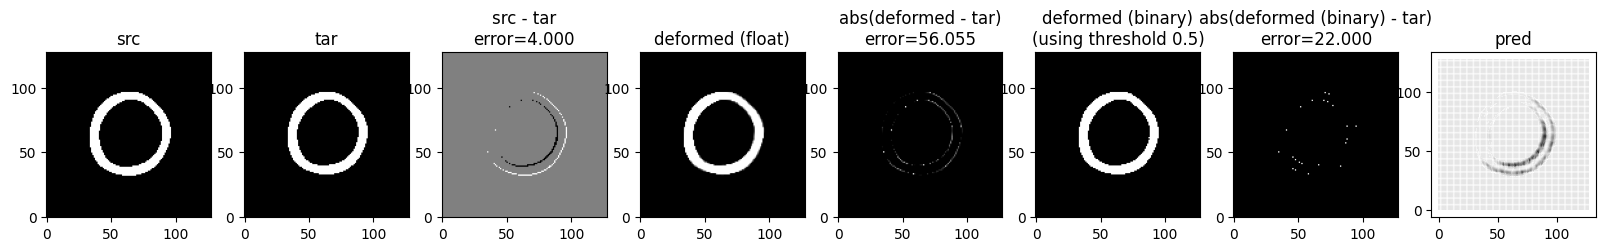

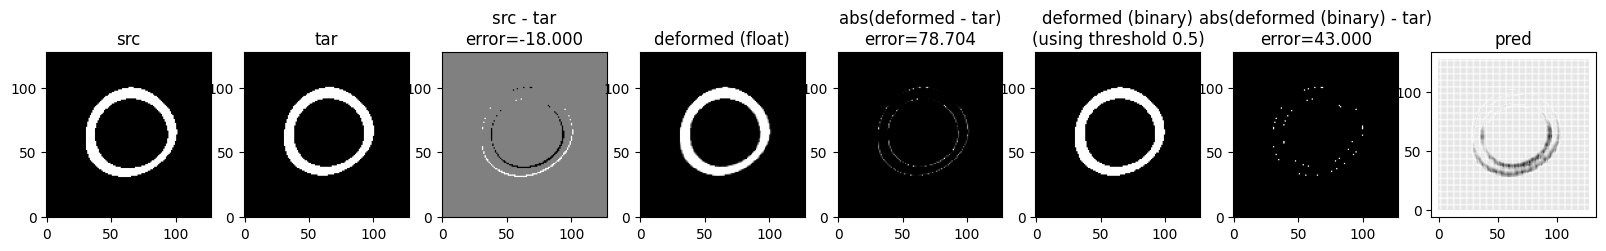

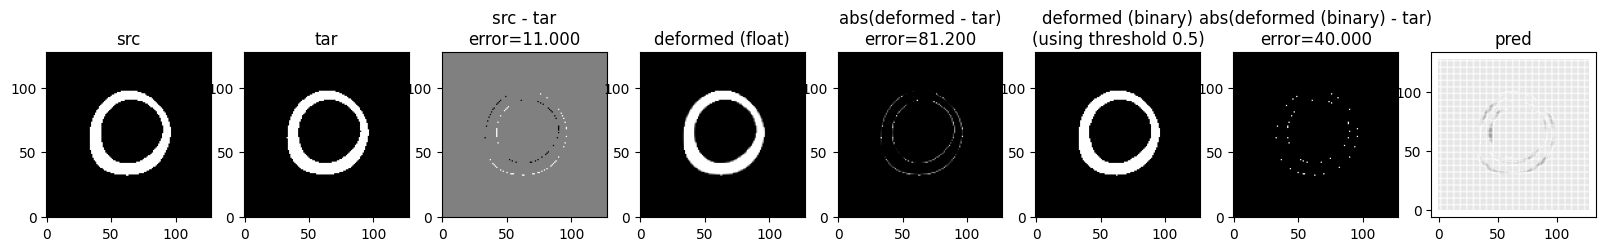

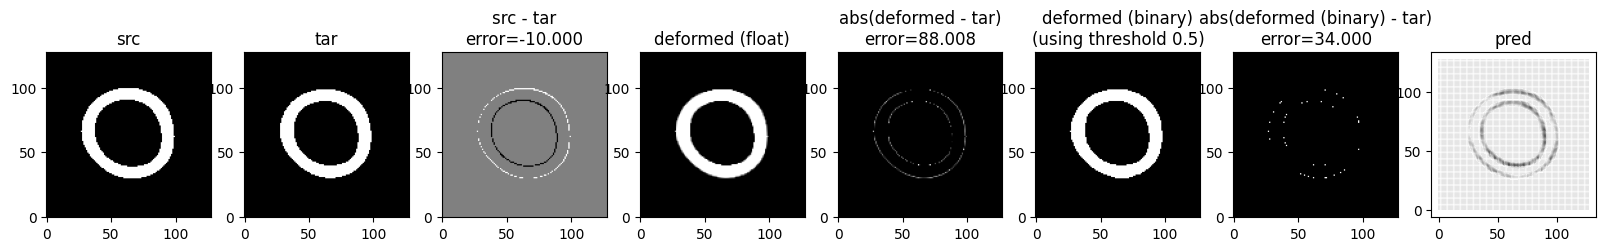

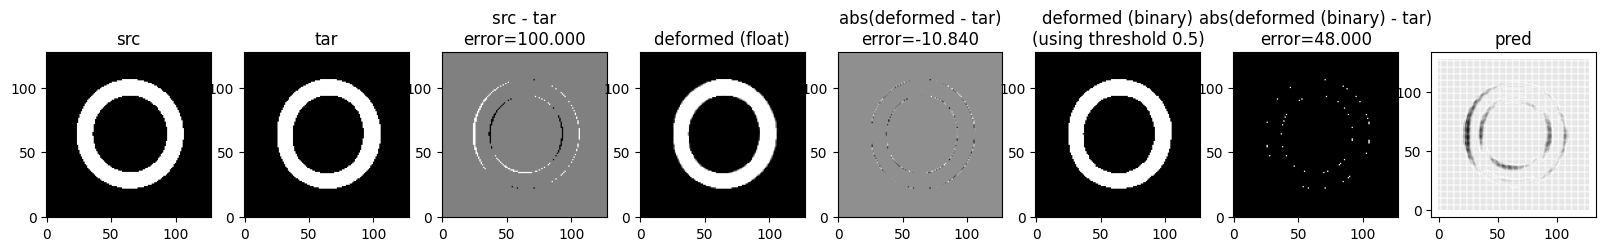

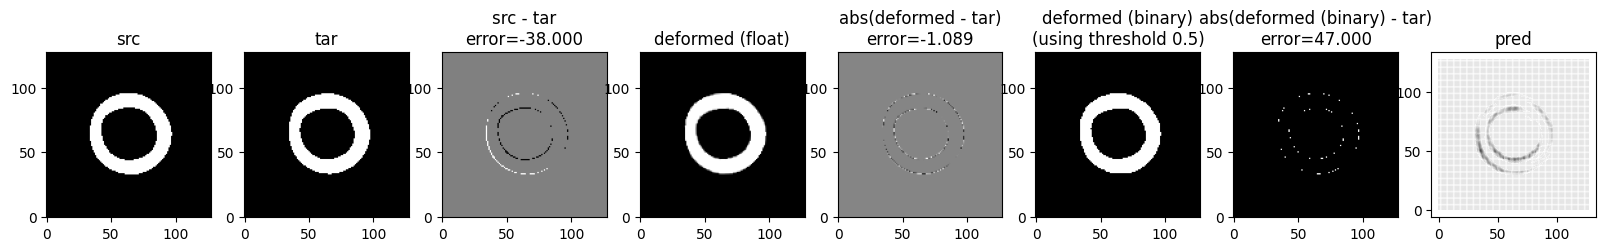

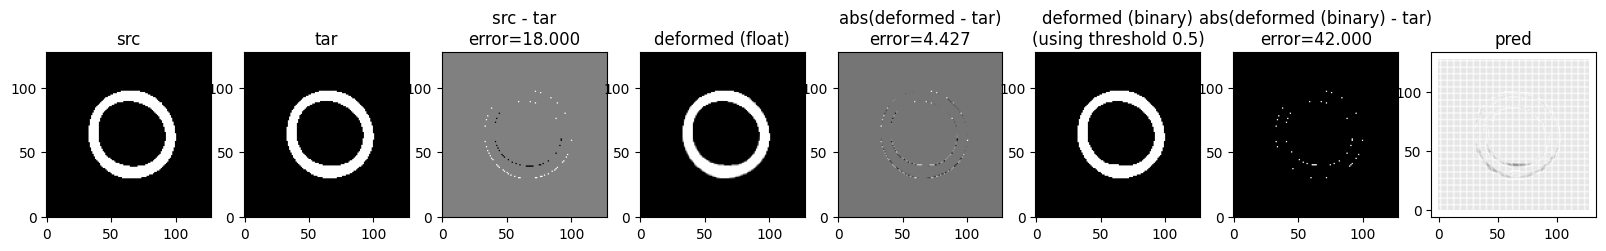

In [18]:
# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
for check_pair_idx in [0,5,10,20]:
    src = train_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = train_pred[check_pair_idx]['tar'][0].astype(float)[0]
    src_tar_diff = src - tar
    deformed = train_pred[check_pair_idx]['deformed_source_pred'][0][0]
    deformed_tar_diff = np.abs(deformed - tar)
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = train_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()

    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_train_{check_pair_idx}.png', bbox_inches='tight')

# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
# for check_pair_idx in [0,5,10,20]:
# for check_pair_idx in [22, 32, 45, 60]:
for check_pair_idx in [22, 32, 45]:
    src = test_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = test_pred[check_pair_idx]['tar'][0].astype(float)[0]
    # src_tar_diff = np.abs(src - tar)
    src_tar_diff = src - tar
    deformed = test_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    deformed_tar_diff = deformed - tar
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = test_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')
    
    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_test_{check_pair_idx}.png', bbox_inches='tight')


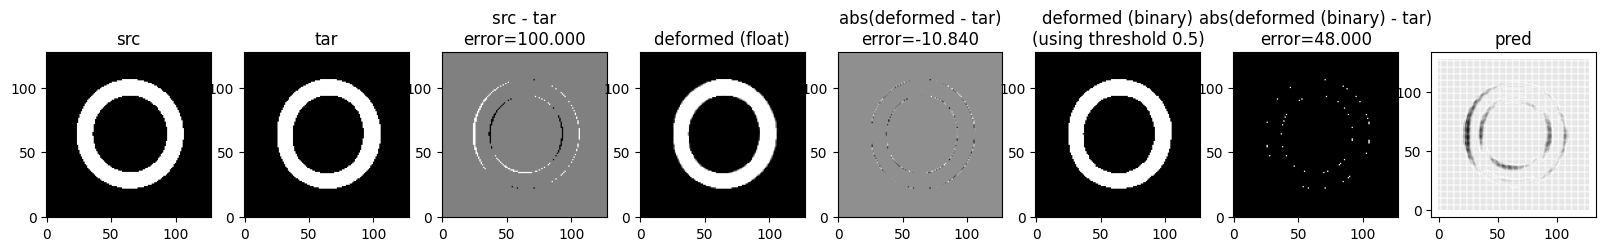

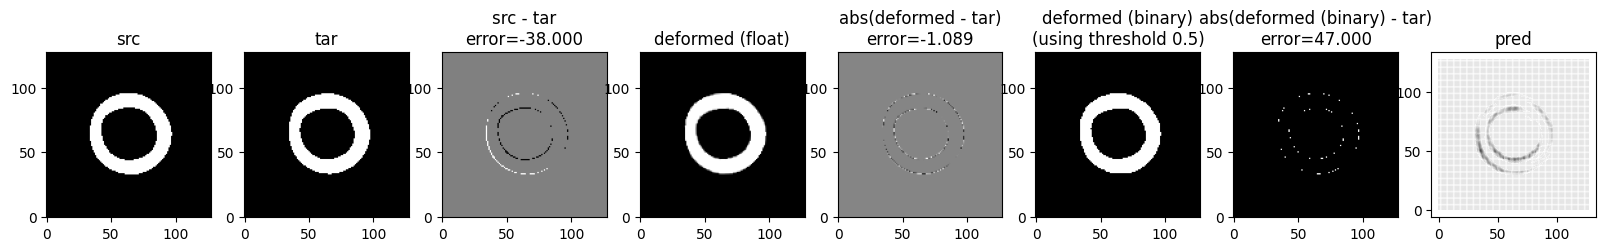

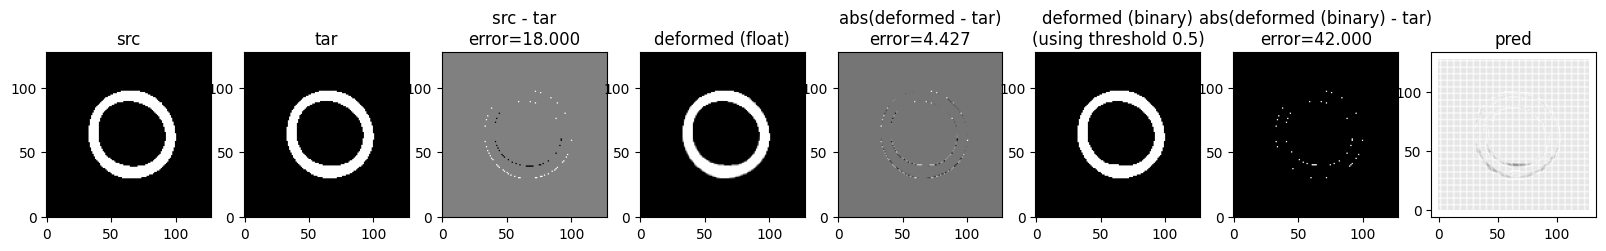

In [19]:
# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
# for check_pair_idx in [0,5,10,20]:
# for check_pair_idx in [22, 32, 45, 60]:
for check_pair_idx in [22, 32, 45]:
    src = test_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = test_pred[check_pair_idx]['tar'][0].astype(float)[0]
    # src_tar_diff = np.abs(src - tar)
    src_tar_diff = src - tar
    deformed = test_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    deformed_tar_diff = deformed - tar
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = test_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')
    
    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_test_{check_pair_idx}.png', bbox_inches='tight')
